# Comparing spatial indexing methods with NYC Wi-Fi hotspots data.

In this example, we show how to create k-d tree and quadtree from real dataset, then we compare the querying performance among an **ordinary list**, a **k-d tree**, and a **quadtree**.

There is a public dataset (https://www.kaggle.com/new-york-city/nyc-public-wifi) containing over 2,500 records of every public WiFi hotspot in New York City as of Aug 2011. The specific task is to find all WiFi hotspots within a certain radius of a certain location.

For example, we are interested in searhing all the hotspots within 0.5 mile of the Central Park (40.7812 N, 73.9665 W).

We will use the kd-tree code from `scipy.spatial` library. For the quadtree, we will need to use the code posted on Learn. 

For benchmarking the run time, please use the **%timeit** magic function.


Conclusion: We find that using a **quadtree** in this case outperforms the other two data structures.


#### Step 0: Import libraries

In [16]:
from scipy import spatial
import numpy as np
import math
import pandas as pd
import geopandas as gpd

#### Step 1.1: Import the WiFi dataset as a pandas DataFrame
#### Step 1.2: Convert it to a geopandas GeoDataFrame by using the longitude and latitude columns as the geometries.
#### Step 1.3: Specifcy the coordinate system as WGS84 (EPSG:4326), then convert to Web Mercator (EPSG:3395), so the unit of the coordinate changes from degrees to meters.


In [2]:
df = pd.read_csv("nyc-wi-fi-hotspot-locations.csv")

gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=
                    gpd.points_from_xy(x=df.Longitude, y=df.Latitude)).to_crs("EPSG:3395")

#### Simply plot it, to check out the spatial distribution

<AxesSubplot:>

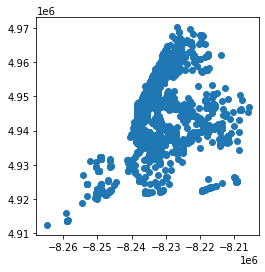

In [3]:
gdf.plot()

#### Step 2.1: Use the pyproj library to project the coordinates of the central park to Web Mercator.
#### Step 2.2: Specipy the searching radius to be 0.5 mile.

In [4]:
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:4326", "epsg:3395")
central_park = transformer.transform(40.7812, -73.9665)

search_radius = 0.5*1000*1.61 #1 mile

#### Step 3: Retrive the coordinates in the Wifi hotstops GeoDataFrame and convert them to a numpy array. 

In [5]:
coords = np.array(list(zip(gdf.geometry.x,gdf.geometry.y)))

#### Step 4: Build a k-d tree using `spatial.KDTree()` and coordinates above.
#### Step 4.1 : Perform a circular search by using `tree.query_ball_point()` with the central park location and search radius specified above.

In [6]:
tree = spatial.KDTree(coords)
rslt_index_kd_tree = tree.query_ball_point(central_park, search_radius)

#### `tree.query_ball_point()` returns the indices of all WiFi hotspots within 0.5mi of the location.

In [7]:
rslt_index_kd_tree

[1651, 2397, 1602, 1604]

#### Plug-in the indices in the GeoDataFrame to find detailed attributes of each nearby hotspot. There are in total 4 available public WiFi hotspots

In [8]:
gdf.iloc[rslt_index_kd_tree,]

,OBJECTID,Borough,Type,Provider,Name,Location,Latitude,Longitude,X,Y,...,CounDist,Postcode,BoroCD,CT2010,BCTCB2010,BIN,BBL,DOITT_ID,"Location (Lat, Long)",geometry
1651,7642,MN,Free,LinkNYC - Citybridge,mn-08-121049,36 EAST 84 STREET,40.779454,-73.959681,995416.391697,223255.452161,...,4.0,10028,108.0,142.0,1014200.0,1046787.0,1.014950e+09,3920,"{'longitude': '-73.959681', 'human_address': '...",POINT (-8233154.028 4951950.863)
2397,7875,MN,Free,LinkNYC - Citybridge,mn-08-121051,40 EAST 83 STREET,40.778795,-73.960116,995296.090101,223015.240699,...,4.0,10028,108.0,142.0,1014200.0,1046768.0,1.014940e+09,4153,"{'longitude': '-73.960116', 'human_address': '...",POINT (-8233202.452 4951854.358)
1602,2140,MN,Free,Transit Wireless,"81st Street - Museum of Natural History - B, C",81st Street - Museum of Natural History,40.781433,-73.972143,991964.776881,223975.194160,...,6.0,83,164.0,143.0,1014300.0,0.0,0.000000e+00,1543,"{'longitude': '-73.972143', 'human_address': '...",POINT (-8234541.292 4952240.678)
1604,2142,MN,Free,Transit Wireless,"86th Street - Central Park West - B, C",86th Street - Central Park West,40.785868,-73.968916,992857.895830,225591.316256,...,6.0,83,164.0,143.0,1014300.0,0.0,0.000000e+00,1545,"{'longitude': '-73.968916', 'human_address': '...",POINT (-8234182.064 4952890.194)


#### Step 5.1 : Copy your distance calculation function from A1
#### Step 5.2 : Loop over the WiFi coordinates array, and for each WiFi hotspot, calculate the distance between the WiFi hotspot and the central park. If it is within 0.5 mile, add it to a list. In the end, return all found hotspots.

In [9]:
def eu_dist(pt_1, pt_2):
    dist = math.sqrt(((pt_1[0]-pt_2[0])**2)+((pt_1[1]-pt_2[1])**2))
    return dist

def list_query(coords, pt, dist):
    rslt = []
    for i in range(len(coords)):
        if eu_dist(coords[i], pt) <= dist:
            rslt.append(i)
    return rslt

#### Query Wifi hotspots using the function defined above, which will return the indices of each nearby Wifi hotspot.

In [10]:
rslt_index_list = list_query(coords, central_park, search_radius)

#### Plug-in the indices in the GeoDataFrame to find detailed attributes of each nearby hotspot.

In [11]:
gdf.iloc[rslt_index_list,]

,OBJECTID,Borough,Type,Provider,Name,Location,Latitude,Longitude,X,Y,...,CounDist,Postcode,BoroCD,CT2010,BCTCB2010,BIN,BBL,DOITT_ID,"Location (Lat, Long)",geometry
1602,2140,MN,Free,Transit Wireless,"81st Street - Museum of Natural History - B, C",81st Street - Museum of Natural History,40.781433,-73.972143,991964.776881,223975.194160,...,6.0,83,164.0,143.0,1014300.0,0.0,0.000000e+00,1543,"{'longitude': '-73.972143', 'human_address': '...",POINT (-8234541.292 4952240.678)
1604,2142,MN,Free,Transit Wireless,"86th Street - Central Park West - B, C",86th Street - Central Park West,40.785868,-73.968916,992857.895830,225591.316256,...,6.0,83,164.0,143.0,1014300.0,0.0,0.000000e+00,1545,"{'longitude': '-73.968916', 'human_address': '...",POINT (-8234182.064 4952890.194)
1651,7642,MN,Free,LinkNYC - Citybridge,mn-08-121049,36 EAST 84 STREET,40.779454,-73.959681,995416.391697,223255.452161,...,4.0,10028,108.0,142.0,1014200.0,1046787.0,1.014950e+09,3920,"{'longitude': '-73.959681', 'human_address': '...",POINT (-8233154.028 4951950.863)
2397,7875,MN,Free,LinkNYC - Citybridge,mn-08-121051,40 EAST 83 STREET,40.778795,-73.960116,995296.090101,223015.240699,...,4.0,10028,108.0,142.0,1014200.0,1046768.0,1.014940e+09,4153,"{'longitude': '-73.960116', 'human_address': '...",POINT (-8233202.452 4951854.358)


#### Step 6.1 We create a quadtree using the code provided. First we need to define a bounding box, and the center of the box.
#### Step 6.2 Use the box and center to create a `Rect()` object then plug-in to the `Quadtree()`.
#### Step 6.3 Loop over the WiFi locations and for each one, create a `Point()` object then insert to the quadtree with `QuadTree.insert()`
#### Step 6.4 Make a query using `QuadTree.query_radius()` with central park location, searching radius, and an empty list as arguments. it will return the records that are nearby central park within 0.5 mile.

In [12]:
from quadtree import Point, Rect, QuadTree

box = np.max(coords,axis=0) - np.min(coords,axis=0)
center = np.mean(coords,axis=0)

qtree = QuadTree(Rect(center[0], center[1], box[0], box[1]))

for i in range(len(coords)):
    point = Point(coords[i][0],coords[i][1],label=df["Name"][i])
    qtree.insert(point)

qtree.query_radius(central_park, search_radius, [])

[(-8233154.02815295, 4951950.863011102): 'mn-08-121049',
 (-8233202.4521314455, 4951854.357530273): 'mn-08-121051',
 (-8234541.291647216, 4952240.678137327): '81st Street - Museum of Natural History - B, C',
 (-8234182.0636504255, 4952890.194370422): '86th Street - Central Park West - B, C']

#### Step 7: The final step is to compare the speed for each data structure's querying method. We use `%timeit ` which is a magic function in front of each function call to benchmark the runtime.

#### We can see that `list_query()` takes ~5 ms, `qtree.query_radius()` takes ~90 µs, and `tree.query_ball_point()` takes ~1.3 ms. Obviously we see quadtree is faster than kd-tree than list in this example.

In [13]:
%timeit list_query(coords, central_park, search_radius)

5.01 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%timeit qtree.query_radius(central_park, search_radius, [])

91.1 µs ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%timeit tree.query_ball_point(central_park, search_radius)

1.27 ms ± 72.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
